# Example of implementing a QAOA for MAX CUT problem using Qiskit, simulator.
```python

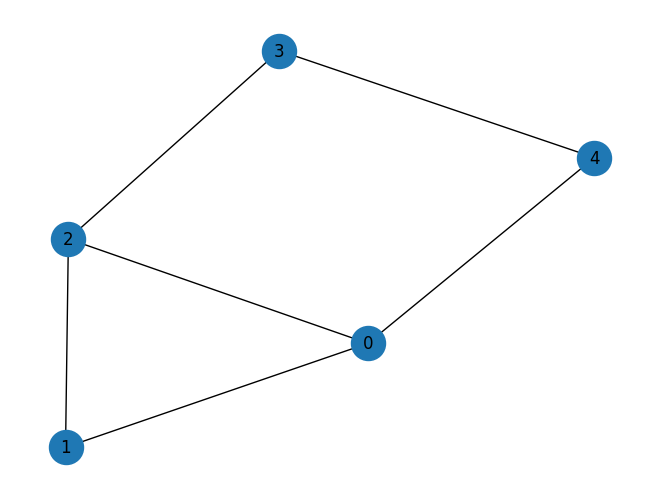

In [35]:
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np

n = 5

graph = rx.PyGraph()
graph.add_nodes_from(np.arange(0, n, 1))
edge_list = [(0, 1, 1.0), (0, 2, 1.0), (0, 4, 1.0), (1, 2, 1.0), (2, 3, 1.0), (3, 4, 1.0)]
graph.add_edges_from(edge_list)
draw_graph(graph, node_size=600, with_labels=True)

In [36]:
from qiskit.quantum_info import SparsePauliOp
def build_max_cut_paulis(graph: rx.PyGraph) -> list[tuple[str, float]]:
    """Convert the graph to Pauli list.

    This function does the inverse of `build_max_cut_graph`
    """
    pauli_list = []
    for edge in list(graph.edge_list()):
        paulis = ["I"] * len(graph)
        paulis[edge[0]], paulis[edge[1]] = "Z", "Z"

        weight = graph.get_edge_data(edge[0], edge[1])

        pauli_list.append(("".join(paulis)[::-1], weight))

    return pauli_list


max_cut_paulis = build_max_cut_paulis(graph)

cost_hamiltonian = SparsePauliOp.from_list(max_cut_paulis)
print("Cost Function Hamiltonian:", cost_hamiltonian)

Cost Function Hamiltonian: SparsePauliOp(['IIIZZ', 'IIZIZ', 'ZIIIZ', 'IIZZI', 'IZZII', 'ZZIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


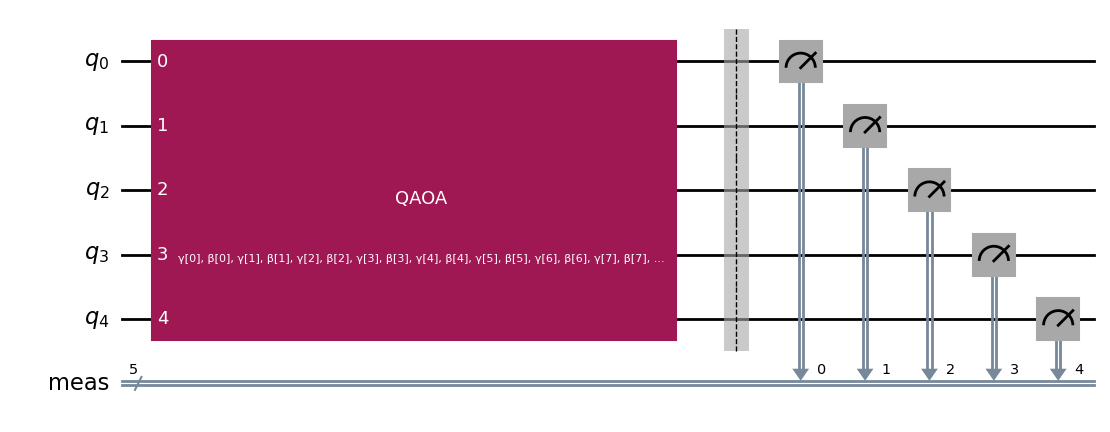

In [37]:
from qiskit.circuit.library import QAOAAnsatz
reps = 10
circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=reps)
circuit.measure_all()

circuit.draw('mpl')

In [38]:
initial_gamma = np.pi
initial_beta = np.pi/2
init_params = [initial_gamma, initial_beta] * reps
print("Parameters:", circuit.parameters)
print("Initial params:", init_params)   

Parameters: ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(β[1]), ParameterVectorElement(β[2]), ParameterVectorElement(β[3]), ParameterVectorElement(β[4]), ParameterVectorElement(β[5]), ParameterVectorElement(β[6]), ParameterVectorElement(β[7]), ParameterVectorElement(β[8]), ParameterVectorElement(β[9]), ParameterVectorElement(γ[0]), ParameterVectorElement(γ[1]), ParameterVectorElement(γ[2]), ParameterVectorElement(γ[3]), ParameterVectorElement(γ[4]), ParameterVectorElement(γ[5]), ParameterVectorElement(γ[6]), ParameterVectorElement(γ[7]), ParameterVectorElement(γ[8]), ParameterVectorElement(γ[9])])
Initial params: [3.141592653589793, 1.5707963267948966, 3.141592653589793, 1.5707963267948966, 3.141592653589793, 1.5707963267948966, 3.141592653589793, 1.5707963267948966, 3.141592653589793, 1.5707963267948966, 3.141592653589793, 1.5707963267948966, 3.141592653589793, 1.5707963267948966, 3.141592653589793, 1.5707963267948966, 3.141592653589793, 1.5707963267948966, 3.14

In [39]:
from qiskit_aer.primitives import Estimator as AerEstimator
from scipy.optimize import minimize

objective_func_vals = []

estimator = AerEstimator()
estimator.set_options(shots=1000)

def cost_func_estimator(params, ansatz, hamiltonian, estimator):
    circuit_bound = ansatz.assign_parameters(params)
    job = estimator.run([circuit_bound], [hamiltonian])
    result = job.result()
    cost = result.values[0]
    objective_func_vals.append(cost)
    return cost

result = minimize(
    cost_func_estimator,
    init_params,
    args=(circuit, cost_hamiltonian, estimator),
    method="COBYLA",
    tol=1e-10,
    options={'maxiter': 1000}
)

print("Optimization Result:\n", result)

Optimization Result:
  message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -2.334
       x: [ 4.285e+00  1.684e+00 ...  4.117e+00  1.568e+00]
    nfev: 370
   maxcv: 0.0


# Energetic landscape on a symmetric cut of the parameters

In [ ]:
estimator = AerEstimator()
estimator.set_options(shots=1000)

# Create values ​​grid
beta_vals = np.linspace(0, np.pi, 50)
gamma_vals = np.linspace(0, 2*np.pi, 50)
Z = np.zeros((len(beta_vals), len(gamma_vals)))

# Evaluate the cost function for each combination of beta and gamma
for i, beta in enumerate(beta_vals):
    for j, gamma in enumerate(gamma_vals):
        param_dict = dict(zip(circuit.parameters, [beta, gamma]*reps))
        bound_circuit = circuit.assign_parameters(param_dict)
        job = estimator.run([bound_circuit], [cost_hamiltonian])
        result2 = job.result()
        Z[i, j] = result2.values[0]

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Graph the energy landscape
B, Gm = np.meshgrid(gamma_vals, beta_vals)
plt.figure(figsize=(8,6))
cp = plt.contourf(Gm, B, Z, levels=100, cmap='viridis')
plt.colorbar(cp)
plt.xlabel(r'$\gamma$')
plt.ylabel(r'$\beta$')
plt.title('Energy landscape ⟨H⟩ IN QAOA (p={})'.format(reps))
plt.show()

# Create parameter mesh for the X axis (gamma) and y (beta)
BETA, GAMMA = np.meshgrid(beta_vals, gamma_vals, indexing='ij')

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Surface
surf = ax.plot_surface(
    GAMMA, BETA, Z, 
    cmap='viridis', 
    edgecolor='none', 
    alpha=0.9
)

ax.set_xlabel(r'$\gamma$')
ax.set_ylabel(r'$\beta$')
ax.set_zlabel(r'$\langle H \rangle$')
ax.set_title('QAOA energy landscape (p={})'.format(reps))
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
plt.tight_layout()
plt.show()


# Cost convergence by classical optimization of parameters

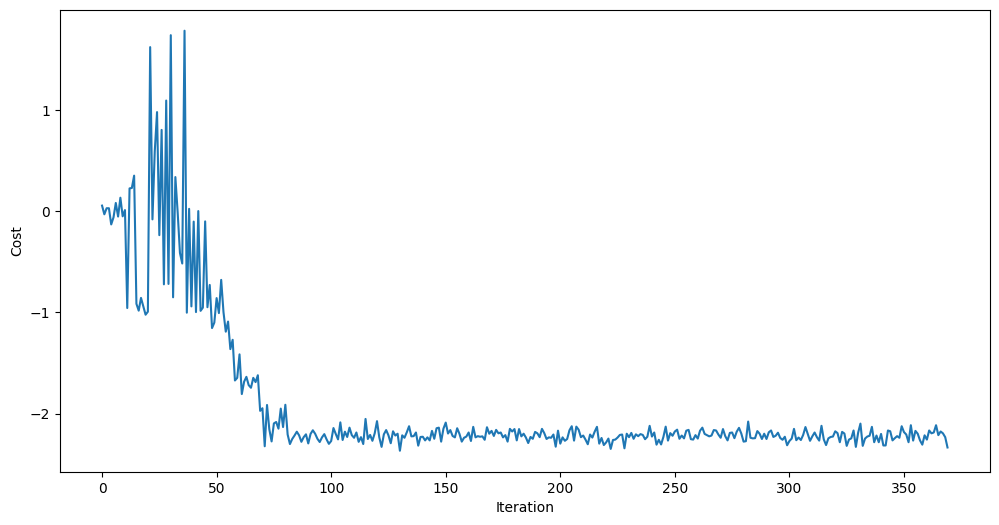

In [42]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

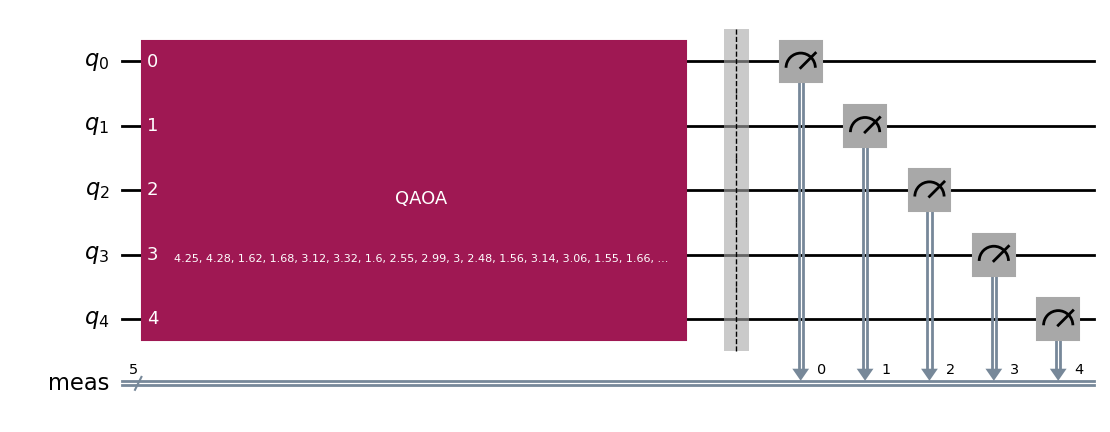

In [43]:
optimized_circuit = circuit.assign_parameters(result.x)
optimized_circuit.draw('mpl', fold=False, idle_wires=False)

# Results for the best parameters

{'10110': 0.0871, '10100': 0.0849, '00101': 0.1442, '11010': 0.1367, '11000': 0.0064, '01001': 0.0793, '01101': 0.0501, '01011': 0.0887, '11110': 0.0044, '11001': 0.0098, '11011': 0.0053, '10101': 0.0563, '01010': 0.0491, '10010': 0.0573, '01110': 0.015, '00011': 0.0092, '10011': 0.0149, '00010': 0.0167, '11100': 0.0097, '11101': 0.0148, '00110': 0.0114, '01100': 0.0147, '00111': 0.0074, '00001': 0.0043, '10001': 0.0137, '00100': 0.0055, '00000': 0.0005, '01111': 0.0006, '01000': 0.0005, '10000': 0.0006, '11111': 0.0003, '10111': 0.0006}


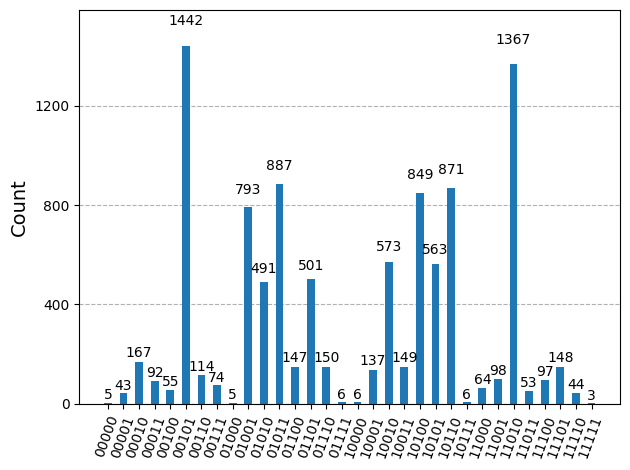

In [44]:
from qiskit import transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram


# Transpilar para el simulador
simulator = Aer.get_backend('aer_simulator')
transpiled_circuit = transpile(optimized_circuit, simulator)

# Ejecutar el circuito
shots = 10_000
job = simulator.run(transpiled_circuit, backend=simulator, shots=shots)
result = job.result()

# Obtener conteos
counts = result.get_counts()

# Normalizar los resultados
final_distribution = {key: val/shots for key, val in counts.items()}

print(final_distribution)
plot_histogram(counts)


In [45]:
keys = list(final_distribution.keys())
values = list(final_distribution.values())
most_likely = keys[np.argmax(np.abs(values))]

result_bitstring = [int(digit) for digit in most_likely]
print("Result bitstring as list:", result_bitstring)


Result bitstring as list: [0, 0, 1, 0, 1]


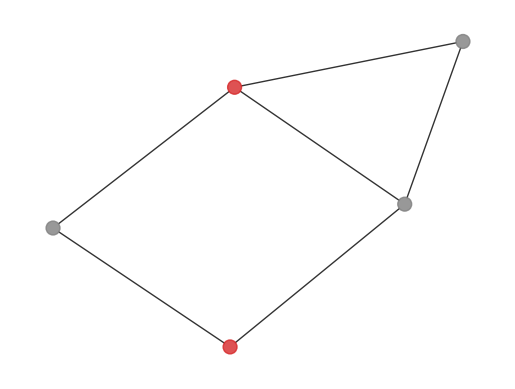

In [50]:
# auxiliary function to plot graphs

def plot_result(G, x):
    colors = ["tab:grey" if i == 0 else "tab:red" for i in x]
    pos, default_axes = rx.spring_layout(G), plt.axes(frameon=True)
    rx.visualization.mpl_draw(G, node_color=colors, node_size=100, alpha=0.8, pos=pos)

plot_result(graph, result_bitstring)